必要なモジュールをインポートする。

# ふ 
## ki 
### o
$k_i$

In [2]:
%matplotlib inline

import numpy as np
import math 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

rosenbrock関数である。図は2変数の場合である。

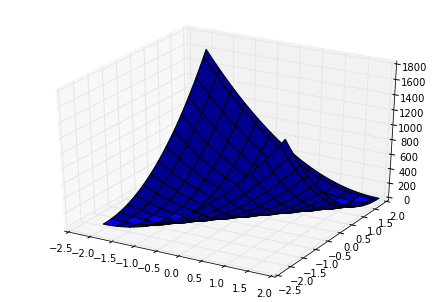

In [62]:
def rosenbrock(x):
    z = 0
    for i in range(1, len(x)):
        z += 100*pow(x[0] - x[i], 2) + pow(1 - x[i], 2)
    return z

fig = pl.figure()
ax = Axes3D(fig)

X = np.arange(-2.048, 2.048, 0.1)

X, Y = np.meshgrid(X, X)
Z = example1([X, Y])

ax.plot_surface(X, Y, Z, rstride=3, cstride=3)

pl.show()

SAとPSOを用いて実験を行う。

①先にSAで検証する。以下は提出したコードと同じ、SAのコードである。

In [487]:
class SA:
    #引数にはN:変数の数、x:変数の下限と上限、init_T:温度の初期値、をとる。
    def __init__(self, N=50, x=[-2.048, 2.048], init_T=100):
        self.x = np.array([np.random.uniform(x[0], x[1]) for i in range(N)])
        self.T = init_T
        self.N = N
        self.index = np.array([i for i in range(N)])
    
    #annealingで使うための関数である。
    def copy_x(self, change):
        x = np.zeros(self.N)
        for i in range(self.N):
            if i != change:
                x[i] = self.x[i]
            else:
                a = np.random.choice([0, 1])
                if a == 0:
                    x[change] += 0.001*np.random.uniform(0, 2)
                else:
                    x[change] -= 0.001*np.random.uniform(0, 2)
        return x
      
    def annealing(self):
        
        change = np.random.choice(self.index)
        #配列xのうち変更するインデックスを決定する。
        
        x = self.copy_x(change)
        #x[change]を正または負の方向にわずかに動かす。
            
        energy = self.accept(x) - self.accept(self.x)
        #変更前と変更後のエネルギー差。
       
        #エネルギーが低くなれば値を更新、そうでなくとも一定の確率(Tに依存)で更新。
        if energy < 0:
            self.x = x　
        else:
            p = pow(math.e, -energy/self.T)
            b = np.random.choice([0, 1], p=[p, 1-p])
            if b == 0:
                self.x = x
    
    #エネルギーの冷却
    def cooling(self):
        self.T = self.T*0.95
    
    #rosenbrock関数の計算。
    def accept(self, x):    
        cal = rosenbrock(x)
        return cal
    
    #n回繰り返す。
    def simulate(self, n):
        self.log = np.array([])
        for i in range(n):
            self.annealing()
            self.cooling()
            self.log = np.append(self.log, self.accept(self.x))
        return self.log[-1]

SAを1000回繰り返す。下はrosenbrock関数が返す値の推移である。

In [605]:
sa = SA()
sa.simulate(1000)

48.825836849655452

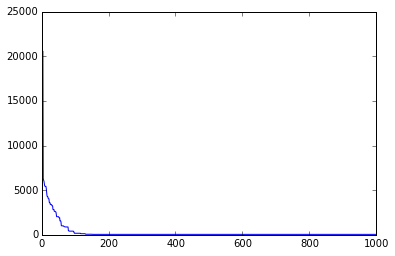

In [606]:
plt.plot(sa.log)

何回か繰り返したが大体48を返すxの組み合わせで更新が止まってしまう（以下で再検討）。

②次にPSOで検討する。以下は提出したコードと同じ、PSOのコードである。

In [587]:
#粒子を表す。
class particle:
    #引数の意味はx:粒子の位置、v:粒子の速度、alpha,beta,ganmaは速度更新で重みの調整に使われる。
    def __init__(self, x, v, omega, alpha, beta, ganma):
        self.x = x
        self.v = v
        self.omega = omega
        self.alpha = alpha
        self.beta = beta
        self.ganma = ganma
        self.lbest_x = x
        self.lbest = 10000
    
    #その粒子のローカルベストを返す関数。   
    def local_best(self):
        cal = rosenbrock(self.x)
        if self.lbest > cal:
            self.lbest = cal
            self.lbest_x = self.x
    
    #vの値の更新。
    def renew_v(self, gbest_x):
        r_1 = np.random.uniform()
        r_2 = np.random.uniform()
        self.v = self.ganma*(self.omega*self.v + (self.lbest_x - self.x)*self.alpha*r_1 + (gbest_x - self.x)*self.beta*r_2)
    #xの値の更新。
    def renew_x(self):
        self.x = self.x + self.v

#PSO全体のクラス。
class PSO:
    #引数の意味はN:変数の数、pN:粒子の数、limit_x:変数（粒子の位置）の下限と上限、残りはそれぞれ対応する変数の下限と上限（値は経験的に決めた）。
    def __init__(self, N=50, pN=100, limit_x=[-2.048, 2.048], limit_v=[0.0, 0.01], limit_omega=[0.8, 1.0], limit_alpha=[0.0, 1.0], limit_beta=[0.0, 1.0], limit_ganma=[0.8, 1.0]):
        #Alpha is Attenuation coefficient.
        #Omega is Convergence factor.
        #N is the number of iteration. Exit condition is given by the number of iteration.
        self.N = N
        self.pN = pN
        self.limit_x = limit_x
        self.limit_v = limit_v
        self.limit_omega = limit_omega
        self.limit_alpha = limit_alpha
        self.limit_ganma = limit_ganma
        self.limit_beta = limit_beta
        self.GBest = 10000
        self.GBest_x = np.array([np.random.uniform(limit_x[0], limit_x[1]) for i in range(N)])
    
    #以下、initialize_?関数は?の初期化を行う。
    def initialize_x(self):   
        x = np.array([np.random.uniform(self.limit_x[0], self.limit_x[1]) for i in range(self.N)])
        return x
    
    def initialize_v(self):
        v = np.array([np.random.uniform(self.limit_v[0], self.limit_v[1]) for i in range(self.N)])
        return v
        
    def initialize_omega(self):
        omega = np.array([np.random.uniform(self.limit_omega[0], self.limit_omega[1]) for i in range(self.N)])
        return omega
        
    def initialize_alpha(self):
        alpha = np.array([np.random.uniform(self.limit_alpha[0], self.limit_alpha[1]) for i in range(self.N)])
        return alpha
    
    def initialize_beta(self):
        beta = np.array([np.random.uniform(self.limit_beta[0], self.limit_beta[1]) for i in range(self.N)])
        return beta
    
    def initialize_ganma(self):
        ganma = np.array([np.random.uniform(self.limit_ganma[0], self.limit_ganma[1]) for i in range(self.N)])
        return ganma
     
    #粒子をセットする。配列に粒子オブジェクトを格納する。
    def set_particles(self):
        particles = np.array([])
        for i in range(self.pN):
            particles = np.append(particles, particle(self.initialize_x(), self.initialize_v(), self.initialize_omega(), self.initialize_alpha(), self.initialize_beta(), self.initialize_ganma()))
            particles[i].local_best()
            if particles[i].lbest < self.GBest:
                self.GBest = particles[i].lbest 
                self.GBest_x = particles[i].lbest_x
            particles[i].renew_v(self.GBest_x)
            self.particles = particles
    
    #n回シミュレートする。GBestはグローバルベストを示す。
    def simulate(self, n):
        self.set_particles()
        for t in range(n):
            for i in range(self.pN):
                self.particles[i].renew_x()
                self.particles[i].local_best()
                if self.particles[i].lbest < self.GBest:
                    self.GBest = self.particles[i].lbest 
                    self.GBest_x = self.particles[i].lbest_x
                self.particles[i].renew_v(self.GBest_x)
        return self.GBest, self.GBest_x
    
    #1回シミュレートする。
    def one_simulate(self, n):
        for t in range(n):
            for i in range(self.pN):
                self.particles[i].renew_x()
                self.particles[i].local_best()
                if self.particles[i].lbest < self.GBest:
                    self.GBest = self.particles[i].lbest 
                    self.GBest_x = self.particles[i].lbest_x
                self.particles[i].renew_v(self.GBest_x)
        return self.GBest, self.GBest_x

PSOを粒子数を100にして100回繰り返す。

In [589]:
pso = PSO()
pso.simulate(100)

(80.199945154042922,
 array([ 0.13878727,  0.13896324, -0.05554943,  0.19902501, -0.11371579,
         0.11491866,  0.16331484,  0.14961004,  0.11660541, -0.09235895,
         0.35089699,  0.14862502,  0.06523156,  0.21452462,  0.1550268 ,
         0.18614066,  0.07890686,  0.02013867,  0.11979719,  0.15778102,
         0.22493326,  0.19372418,  0.15382005, -0.03861247,  0.16905516,
         0.11419595,  0.15383924,  0.03201547,  0.09109896,  0.07215024,
         0.08968035,  0.09441061,  0.31681617,  0.3283168 ,  0.09306199,
         0.13336598,  0.00484491,  0.17371227,  0.18462373,  0.11992683,
         0.16353947,  0.22561245,  0.13710823,  0.19731819,  0.16203386,
         0.08815241,  0.17480088,  0.27374404,  0.142703  ,  0.13305669]))

[test1]収束の推移を視覚化する。以下はそのための関数と、その図。

In [594]:
def test1(n):
    pso = PSO()
    pso.set_particles()
    p = []
    for i in range(n):
        best, best_x = pso.one_simulate(1)
        p.append(best)
    plt.plot(p)

平均的な推移をみるために30回繰り返す実験を10回行っている。

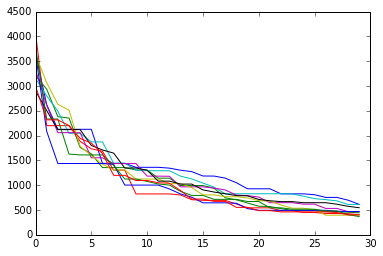

In [595]:
for i in range(10):
    test1(30)

平均的な推移をみるために50回繰り返す実験を10回行っている。

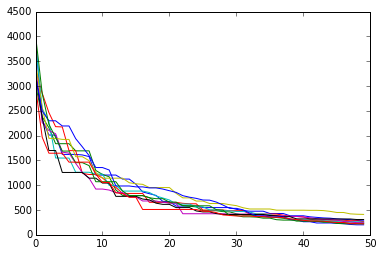

In [596]:
for i in range(10):
    test1(50)

平均的な推移をみるために100回繰り返す実験を2回行っている。

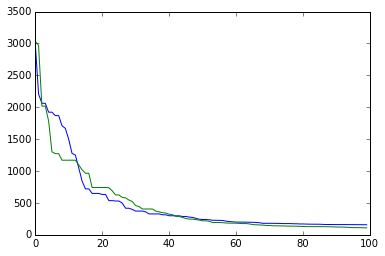

In [597]:
for i in range(2):
    test1(100)

[test2]粒子の数を200に増やしてtest1を行う。以下はそのための関数と、その図。

In [598]:
def test2(n):
    pso = PSO(pN=200)
    pso.set_particles()
    p = []
    for i in range(n):
        best, best_x = pso.one_simulate(1)
        p.append(best)
    plt.plot(p)

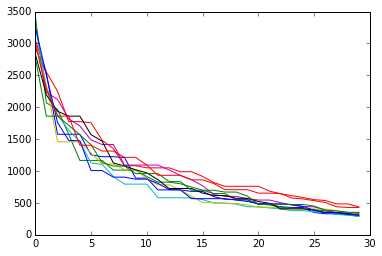

In [600]:
for i in range(10):
    test2(30)

[test3]粒子の数と収束の関係を確認する。以下はそのための関数と、その図。図の見出しは粒子の数。

In [601]:
def test3(n, maxpN):
    pso = PSO(pN=maxpN)
    pso.set_particles()
    p = []
    for i in range(n):
        best, best_x = pso.one_simulate(1)
        p.append(best)
    plt.plot(p, label=maxpN)
    plt.legend()

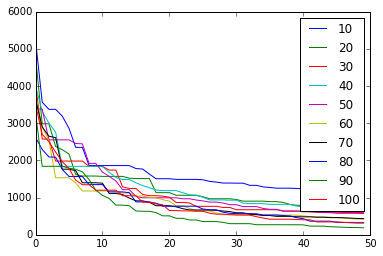

In [602]:
for i in range(1, 11):
    test3(50, i*10)

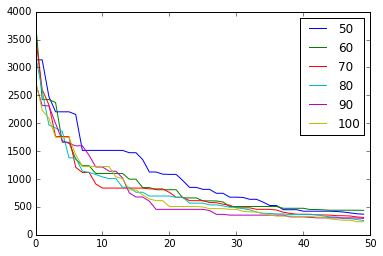

In [603]:
for i in range(5, 11):
    test3(50, i*10)

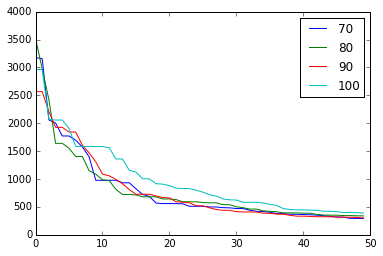

In [191]:
for i in range(7, 11):
    test3(50, i*10)

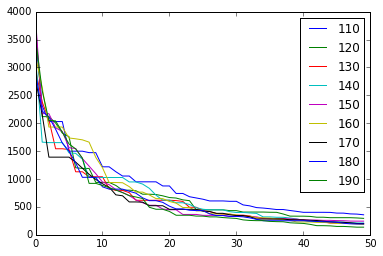

In [604]:
for i in range(11, 20):
    test3(50, i*10)

③SAとPSOを比較する。

1 SAの収束を確認する。rosenbrock関数が返す数がある値になって、xの更新が行われなくなったら試行をとめるテスト。

In [649]:
def test_sa():
    sa = SA()
    a = sa.simulate(10)
    b = sa.simulate(10)
    c = sa.simulate(10)
    p = []
    while c != b and c != a:
        a = b
        b = c
        c = sa.simulate(10)
        p.append(c)
    plt.plot(p[5:])
    print p[-1]

48.8707365824
48.8655512335
48.9315374092
48.934299297
48.9224557411
48.8959971018
48.909997383
48.9496235835
48.8559123193
48.8765231814


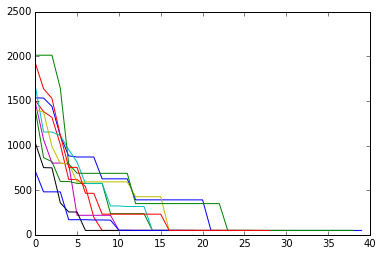

In [650]:
for i in range(10):
    test_sa()

大体、48.9ぐらいの値を返す時点で更新をやめてしまっている。

2 PSOの収束を確認する。rosenbrock関数が返す数がある値になって、xの更新が行われなくなったら試行をとめるテストをしたかったが、収束が終わらなかったので、100回試行するごとにグローバルベストを出力させる。

In [670]:
pso = PSO()
for i in range(100):
    pso.simulate(100)
    print pso.GBest

139.790158456
77.0010689746
68.5177362474
60.4647363547
57.0154341913
56.3356952566
55.0679897255
54.0460821555
53.3774897881
53.0265997897
52.5300400095
52.2053635054
51.7798586972
51.7157858335
51.2507021096
51.1206359952
50.9843304215
50.7881967634
50.5100190138
50.3254839387
50.2153462518
49.9319712891
49.9319712891
49.9227309973
49.8072610123
49.4359262799
49.3388671816
49.0799850307
48.994614056
48.7532243171
48.7532243171
48.4828309703
48.3936304004
48.3148337485
48.1321264063
48.1321264063
47.9537017778
47.7941480585
47.706246907
47.6269025844
47.4381566164
47.2655925271
46.848956856
46.6779703501
46.6170435435
46.5697168502
46.3870409067
46.2460667337
45.8035013556
45.5654579663
45.5654579663
45.5654579663
45.5654579663
45.4497483656
45.2854394398
45.1776408248
45.0530597178
44.9669132665
44.7979696732
44.6797312815
44.5084259445
44.3475444372
44.3475444372
44.1277600838
44.0509349979
43.9347237142
43.9225944781
43.8489347891
43.535899953
43.1819372846
42.9765623648
42.9256057

100回の試行を100回繰り返したが収束は続いている。

In [671]:
for i in range(100):
    pso.simulate(100)
    print pso.GBest

40.5356021793
40.5356021793
40.4304829995
40.2583304656
40.0397582121
39.9742815782
39.8970785107
39.8357188521
39.7630673408
39.7630673408
39.7630673408
39.754210552
39.6358849785
39.5248371907
39.3860179521
39.3035568788
39.2708162459
38.924098955
38.7603797369
38.6624343547
38.5941492022
38.4941433071
38.2418571537
38.1218250538
37.7052711737
37.6880624099
37.5451345176
37.4128829241
37.1679430051
37.0011036467
36.8768436707
36.7933981628
36.6481844348
36.4817917623
36.4116661967
36.3260627311
36.1865288132
36.074668138
36.0310618639
35.9368809198
35.8354555553
35.8004433472
35.8004433472
35.651665768
35.5364634568
35.5325797564
35.3648741749
35.2558349978
35.111706679
35.1005682919
34.9846146211
34.9217947332
34.7839999371
34.7067083906
34.5653780962
34.5126583485
34.3758944986
34.2402619275
34.0958217756
34.091947104
33.9783694847
33.8944695777
33.8435323575
33.8435323575
33.5009604861
33.4497970581
33.3508482996
33.2877292073
33.1450467466
33.0935352284
32.9689622926
32.903070588

続いて100回の試行を100回繰り返した（上と合わせて計20000回）が収束は続いている。

In [672]:
for i in range(20):
    pso.simulate(500)
    print pso.GBest

29.5888186067
28.9752814392
28.3315206043
27.4622428974
26.7788424603
25.9261619788
24.8361671173
24.2226714769
23.4949168795
22.9152354813
22.0916687672
21.4792547446
20.8506420755
20.3612050953
20.0336878955
19.6549605142
19.1821771234
18.6272350446
18.088577982
17.701853656


続いて500回の試行を20回繰り返した（上と合わせて計30000回）が収束は続いている。

In [673]:
for i in range(20):
    pso.simulate(500)
    print pso.GBest

17.4804529127
17.0260699337
16.7060507278
16.507994795
16.0759278516
15.7889878067
15.5651429895
15.0301160407
14.7226649751
14.332811493
14.0046595085
13.761541766
13.4262633563
13.1016241987
12.8031684446
12.5956785622
12.2736387047
12.0211080175
11.7978073034
11.5062278087


続いて500回の試行を20回繰り返した（上と合わせて計40000回）が収束は続いている。

キリがないので、ここでやめる。この時点でのグローバルベストを返す粒子の位置を確認する。

In [675]:
pso.GBest_x

array([ 0.51744218,  0.52127872,  0.51493708,  0.51668488,  0.50877378,
        0.52149627,  0.51797723,  0.52158111,  0.51694406,  0.52280022,
        0.51886261,  0.50916175,  0.51838707,  0.5218209 ,  0.51124669,
        0.52158414,  0.51849197,  0.51214176,  0.52160063,  0.51332496,
        0.51815868,  0.52061813,  0.51734819,  0.52095574,  0.51080635,
        0.52090894,  0.52245423,  0.51706474,  0.51756299,  0.50987128,
        0.52208648,  0.52126006,  0.50235357,  0.51568476,  0.51383177,
        0.52193664,  0.50797243,  0.51623856,  0.51613637,  0.52113666,
        0.51993566,  0.51790321,  0.51839716,  0.52014772,  0.52163532,
        0.51963942,  0.51998654,  0.52138594,  0.52343325,  0.51730242])

大体、すべての値が0.52の近くにいる。これはrosenbrock関数の形的にすべての値が等しいときに、局所最適解になるからだと考えられる。

ここで10000回追加で試行すると、

In [688]:
pso.simulate(10000)

(10.376844211479131,
 array([ 0.55201467,  0.55306506,  0.55641294,  0.55636034,  0.50883038,
         0.55632709,  0.55558955,  0.55640767,  0.55616771,  0.55605902,
         0.53074916,  0.55646223,  0.55545304,  0.55606732,  0.55642982,
         0.55161275,  0.55645009,  0.5563761 ,  0.55648842,  0.55577362,
         0.51815065,  0.55637729,  0.55641572,  0.55637088,  0.54610756,
         0.55638982,  0.55643485,  0.54347541,  0.55638331,  0.55642642,
         0.55517456,  0.52051726,  0.55548733,  0.55643874,  0.55641576,
         0.55588509,  0.54151804,  0.55641166,  0.55633967,  0.55632889,
         0.55638255,  0.55638916,  0.55355037,  0.556161  ,  0.5564221 ,
         0.55648633,  0.55641708,  0.55638209,  0.55636712,  0.54611731]))

となった。すべての値が0.555の近くにいる。これより、おそらくすべての値が等しい状態をできるだけ崩さす大域的最適解に向かっていると考えられる。

すべてのxが1の値をとるとき、rosenbrock関数は0となることを発見している。これが唯一の解かどうかは議論しないが、最初に述べたようにすべてのxが同じ値をとることが局所最適解であり、あるxが他のxと違う値をとると局所最適解ではなくなってしまう。そのためすべての値が1以外の値をとる局所最適解に陥ってしまい、抜け出せなくなると考えられる。SAはその局所最適解にはまっている。PSOは局所最適解に陥りながらも、少しずつすべての値が1になるようにxの値を更新しているように見える。この試行を繰り返せば大域的最適解であると予想されるすべての値が1で、rosenbrock関数が0を返す状態に収束すると考えれらるが、上記で示したように、確かに収束しているものの、収束速度が遅いため最後まで収束させることは省略する。ただし、参考のために下にxの初期値を1のまわりでのみでとった場合の試行を乗せた。以上をもってレポートを締めくくる。

[おまけ:すべてのxが1の値をとるとき、rosenbrock関数は0となることの確認]

In [687]:
c = [1.0 for i in range(50)]
rosenbrock(c)

0.0

PSOでxの初期値を1のまわりでのみでとる。

In [690]:
pso = PSO(limit_x=[0.9, 1.1])
for i in range(10):
    pso.simulate(1000)
    print pso.GBest

0.0366560527931
0.0045582060075
0.00382394823524
0.00361599696818
0.00344061072868
0.00331817283302
0.00312589516001
0.00299619700697
0.00291604942249
0.0028355381286


In [692]:
pso.GBest_x

array([ 1.00758529,  1.00756534,  1.00761468,  1.00751003,  1.00754373,
        1.00764491,  1.00748371,  1.00760992,  1.00762476,  1.00762768,
        1.00754376,  1.00762009,  1.00761184,  1.00773478,  1.00754726,
        1.00761926,  1.00762145,  1.00755215,  1.00754469,  1.00754569,
        1.00753838,  1.00761504,  1.00753901,  1.00751314,  1.0076165 ,
        1.00756088,  1.00752368,  1.00753067,  1.00751844,  1.00762291,
        1.00761966,  1.00758596,  1.00753489,  1.00761955,  1.00762531,
        1.00747925,  1.00756483,  1.00751922,  1.00759597,  1.00752029,
        1.00753566,  1.00754402,  1.00755687,  1.00761641,  1.00763212,
        1.00750786,  1.00784591,  1.00750012,  1.00762008,  1.00762252])

たしかに初期値を1.0付近でとると、予想した通り、すべての値が1.0になるように収束する。